# **Llama-3.1-8B-Classification, LoRa**
## **Classification of validation data; 2 Labels as scale**



# **Set Up**

In [1]:
!pip install huggingface_hub
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install --upgrade wandb
!pip install adapter-transformers

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
adapters 1.1.1 requires transformers~=4.48.3, but you have transformers 4.51.3 which is incompatible.
  Using cached transformers-4.48.3-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.48.3-py3-none-any.whl (9.7 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [2]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools # ??
from tqdm import tqdm
import bitsandbytes as bnb
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer,
                        AutoModel,
                        AutoConfig,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)
from peft import PeftModel
from huggingface_hub import login


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, f1_score, roc_curve, auc, RocCurveDisplay

from scipy.stats import mode

In [3]:
os.getcwd()

'/home/jovyan/llama_final/Validation'

In [4]:
# Hugging face access

with open("../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

In [5]:
torch.cuda.empty_cache()
torch.cuda.is_available()
#torch.cuda.device_count()

True

In [6]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# **Reimport Pretrained Model**

In [7]:
# file paths
base_model = "meta-llama/Llama-3.1-8B" 
finetuned_path = "../Classification/two_labels/attention_LoRa/final_Llama_3.1_8B_saved_model_2labels_scale"

data_path = "data/validation_sample_small.csv"

output_path = "output/Llama_3.1_8B_ft_LoRa_val.csv"



In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# load base model
model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    quantization_config = quantization_config
)


# Add LoRA adapter on top of it
model = PeftModel.from_pretrained(model, finetuned_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(finetuned_path, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id  
model.config.use_cache = False 
model.config.pretraining_pt = 1

# move model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model.to(device) 

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )

In [9]:
# some checks

print("Padding token:", tokenizer.pad_token)
print("Padding token ID:", tokenizer.pad_token_id)

print("Model Configuration:")
print(model.config)

Padding token: <|end_of_text|>
Padding token ID: 128001
Model Configuration:
LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.1-8B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 128001,
  "pretraining_pt": 1,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp

# **Data**

In [62]:
# dictionary for conversions
label_dict = {1: "disagree", 0 : "no_disagreement"}

data = pd.read_csv(data_path)
data

,submission_id,msg_id_parent,msg_id_child,submission_text,body_parent,body_child,subreddit
0,d02aba,ez5hk92,ez5yhvc,"That strategy requires less manpower, less cas...",Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics
1,4gqdyw,d2jsh7b,d2k49x6,It seems that everywhere I go recently I hear ...,This question was asked yesterday.,And the day before that,Ask_Politics
2,9kru18,e719ohl,e719y1u,So after the big headline yesterday about the ...,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics
3,5oui9g,dcm9yt7,dcnqde5,My father tells me trade deals are good for th...,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics
4,4eakff,d1yfonw,d1ygjpd,It sounds controversial and non-traditional to...,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics
5,pxu6lc,hermw07,hetwgsp,I understand that it's more complicated than p...,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics
6,27j18j,ci1ityc,ci1n1c7,Although most if not all were lead by a party ...,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics
7,jn2bon,gb05qjo,gb05rnn,I'm from Canada and it seems to me that most o...,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics
8,8we2i8,e2gbshk,e2go5cs,So walkaway has gone viral whatever that means...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics
9,kzc2cq,gjp0hl0,gjrl8gu,Conservatives long ago lost so many key insti...,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics


In [63]:

# save data
df = pd.DataFrame(data[['submission_id', 'msg_id_parent', 'msg_id_child', 'body_parent', 'body_child', 'subreddit']])
df

,submission_id,msg_id_parent,msg_id_child,body_parent,body_child,subreddit
0,d02aba,ez5hk92,ez5yhvc,Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics
1,4gqdyw,d2jsh7b,d2k49x6,This question was asked yesterday.,And the day before that,Ask_Politics
2,9kru18,e719ohl,e719y1u,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics
3,5oui9g,dcm9yt7,dcnqde5,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics
4,4eakff,d1yfonw,d1ygjpd,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics
5,pxu6lc,hermw07,hetwgsp,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics
6,27j18j,ci1ityc,ci1n1c7,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics
7,jn2bon,gb05qjo,gb05rnn,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics
8,8we2i8,e2gbshk,e2go5cs,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics
9,kzc2cq,gjp0hl0,gjrl8gu,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics


In [64]:
df['prompt'] = None

def make_prompt(row):

    prompt = " Comment: " + str(row["body_parent"]) + "; Reply: " + str(row["body_child"])

    return prompt



df['prompt'] = df.apply(lambda row: make_prompt(row), axis = 1)

# token length checks
df['prompt_len'] = df['prompt'].apply(lambda x: len(x.split()))
df['com_len'] = df['body_parent'].apply(lambda x: len(x.split()))
df['rep_len'] = df['body_child'].apply(lambda x: len(x.split()))
df['len'] = df['com_len'] + df['rep_len']
df['diff'] = df['prompt_len'] - df['len']
df

,submission_id,msg_id_parent,msg_id_child,body_parent,body_child,subreddit,prompt,prompt_len,com_len,rep_len,len,diff
0,d02aba,ez5hk92,ez5yhvc,Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics,Comment: Because the main objective was to se...,28,19,7,26,2
1,4gqdyw,d2jsh7b,d2k49x6,This question was asked yesterday.,And the day before that,Ask_Politics,Comment: This question was asked yesterday. ;...,13,5,5,10,3
2,9kru18,e719ohl,e719y1u,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics,Comment: Does the US grant Visas for the boy...,230,94,134,228,2
3,5oui9g,dcm9yt7,dcnqde5,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics,Comment: Trade deals are good overall fo the ...,304,295,6,301,3
4,4eakff,d1yfonw,d1ygjpd,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics,Comment: The Colorado GOP voted in August to ...,191,150,38,188,3
5,pxu6lc,hermw07,hetwgsp,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics,Comment: I don't think there are any national...,155,80,73,153,2
6,27j18j,ci1ityc,ci1n1c7,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics,Comment: The nominally communist regimes call...,146,52,92,144,2
7,jn2bon,gb05qjo,gb05rnn,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics,Comment: If you measure the collective ideolo...,422,402,18,420,2
8,8we2i8,e2gbshk,e2go5cs,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,"Comment: If it's incredibly fake, the people ...",108,48,57,105,3
9,kzc2cq,gjp0hl0,gjrl8gu,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics,Comment: This has been a theme on the left fo...,275,247,26,273,2


# **Investigate Thresholds by Classification Report**

In [65]:
# dictionary for conversions
label_dict = {1: "disagree", 0 : "no_disagreement"}


def make_predictions(model, df_test, thresholds):

    model.eval()

    # Convert summaries to a list
    sentences = df_test.prompt.tolist()
    
    # Define the batch size
    batch_size = 32  # You can adjust this based on your system's memory capacity
    
    # Initialize an empty list to store the model outputs
    all_outputs = []
    
    # Process the sentences in batches
    for i in tqdm(range(0, len(sentences), batch_size)):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]
    
      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}
    
      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
          
    final_outputs = torch.cat(all_outputs, dim=0)
    probabilities = F.softmax(final_outputs, dim=1)

    # Custom threshold for 'disagree'
    probs_disagree = probabilities[:, 1]
    certainty_scores = torch.max(probabilities, dim=1).values

    probs_disagree_np = probs_disagree.cpu().numpy()
    certainty_scores_np = certainty_scores.cpu().numpy()


    for thresh in thresholds:
        
        predicted_labels = (probs_disagree_np > thresh).astype(int)  # binary prediction
        
        df_test[f'predictions_label_ft_{thresh}'] = predicted_labels
        df_test[f'predictions_score_ft_{thresh}'] = certainty_scores_np
        df_test[f'predictions_ft_{thresh}'] = df_test[f'predictions_label_ft_{thresh}'].apply(lambda l:label_dict[l])
        
    df_test['prob_disagree'] = probs_disagree_np
    
    return df_test


make_predictions(model, df, thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
df

100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


,submission_id,msg_id_parent,msg_id_child,body_parent,body_child,subreddit,prompt,prompt_len,com_len,rep_len,...,predictions_label_ft_0.7,predictions_score_ft_0.7,predictions_ft_0.7,predictions_label_ft_0.75,predictions_score_ft_0.75,predictions_ft_0.75,predictions_label_ft_0.8,predictions_score_ft_0.8,predictions_ft_0.8,prob_disagree
0,d02aba,ez5hk92,ez5yhvc,Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics,Comment: Because the main objective was to se...,28,19,7,...,0,0.962402,no_disagreement,0,0.962402,no_disagreement,0,0.962402,no_disagreement,0.037659
1,4gqdyw,d2jsh7b,d2k49x6,This question was asked yesterday.,And the day before that,Ask_Politics,Comment: This question was asked yesterday. ;...,13,5,5,...,0,0.850586,no_disagreement,0,0.850586,no_disagreement,0,0.850586,no_disagreement,0.149292
2,9kru18,e719ohl,e719y1u,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics,Comment: Does the US grant Visas for the boy...,230,94,134,...,0,0.514648,no_disagreement,0,0.514648,no_disagreement,0,0.514648,no_disagreement,0.485107
3,5oui9g,dcm9yt7,dcnqde5,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics,Comment: Trade deals are good overall fo the ...,304,295,6,...,0,0.995605,no_disagreement,0,0.995605,no_disagreement,0,0.995605,no_disagreement,0.004330
4,4eakff,d1yfonw,d1ygjpd,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics,Comment: The Colorado GOP voted in August to ...,191,150,38,...,0,0.727539,no_disagreement,0,0.727539,no_disagreement,0,0.727539,no_disagreement,0.272461
5,pxu6lc,hermw07,hetwgsp,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics,Comment: I don't think there are any national...,155,80,73,...,0,0.933594,no_disagreement,0,0.933594,no_disagreement,0,0.933594,no_disagreement,0.066589
6,27j18j,ci1ityc,ci1n1c7,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics,Comment: The nominally communist regimes call...,146,52,92,...,1,0.885254,disagree,1,0.885254,disagree,1,0.885254,disagree,0.885254
7,jn2bon,gb05qjo,gb05rnn,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics,Comment: If you measure the collective ideolo...,422,402,18,...,1,0.849121,disagree,1,0.849121,disagree,1,0.849121,disagree,0.849121
8,8we2i8,e2gbshk,e2go5cs,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,"Comment: If it's incredibly fake, the people ...",108,48,57,...,1,0.705566,disagree,0,0.705566,no_disagreement,0,0.705566,no_disagreement,0.705566
9,kzc2cq,gjp0hl0,gjrl8gu,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics,Comment: This has been a theme on the left fo...,275,247,26,...,0,0.955078,no_disagreement,0,0.955078,no_disagreement,0,0.955078,no_disagreement,0.044861


In [36]:
df.columns

Index(['submission_id', 'msg_id_parent', 'msg_id_child', 'body_parent',
       'body_child', 'subreddit', 'prompt', 'prompt_len', 'com_len', 'rep_len',
       'len', 'diff', 'predictions_label_ft_0.5', 'predictions_score_ft_0.5',
       'predictions_ft_0.5', 'predictions_label_ft_0.55',
       'predictions_score_ft_0.55', 'predictions_ft_0.55',
       'predictions_label_ft_0.6', 'predictions_score_ft_0.6',
       'predictions_ft_0.6', 'predictions_label_ft_0.65',
       'predictions_score_ft_0.65', 'predictions_ft_0.65',
       'predictions_label_ft_0.7', 'predictions_score_ft_0.7',
       'predictions_ft_0.7', 'predictions_label_ft_0.75',
       'predictions_score_ft_0.75', 'predictions_ft_0.75',
       'predictions_label_ft_0.8', 'predictions_score_ft_0.8',
       'predictions_ft_0.8'],
      dtype='object')

In [66]:
result = df[['submission_id', 'msg_id_parent', 'msg_id_child', 'prob_disagree',
             'predictions_score_ft_0.5', 'predictions_ft_0.5', 'predictions_ft_0.55', 'predictions_ft_0.6', 
             'predictions_ft_0.65', 'predictions_ft_0.7', 'predictions_ft_0.75', 'predictions_ft_0.8']]


In [67]:
result.to_csv("output/Llama_3.1_8B_ft_LoRa_val_diff_thresholds.csv", index = False)


# **Evaluation**

In [7]:
result_thresholds = pd.read_csv("output/Llama_3.1_8B_ft_LoRa_val_diff_thresholds.csv")

In [8]:
val_data = pd.read_csv("data/majority_validation.csv")
val_data

,submission_id,msg_id_parent,msg_id_child,submission_text,body_parent,body_child,subreddit,label_e,label_c,label_p,majority_label
0,8we2i8,e2gbshk,e2go5cs,So walkaway has gone viral whatever that means...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,disagree,no_disagreement,disagree,disagree
1,17p478l,k8h1qxn,k8ivjmx,Question in a state like Mississippi thats oft...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",Askpolitics,no_disagreement,disagree,no_disagreement,no_disagreement
2,181o366,kaf8us2,kahj2cn,"In the United States, there is a lot about wha...",We need to read more classic literature,May I ask what you consider the classics?,PoliticalDebate,no_disagreement,no_disagreement,no_disagreement,no_disagreement
3,18rqy2g,kf37doz,kf54umb,Federal Revenue FY 2022 Budget -- Income Taxe...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,PoliticalDebate,no_disagreement,disagree,disagree,disagree
4,4dgyfc,d1qsqkm,d1r17xo,"In an appearance on CNN's New Day, Jeff Weaver...",Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,PoliticalDiscussion,no_disagreement,disagree,no_disagreement,no_disagreement
5,18fxb9q,kd28j8o,kdb3j9u,Milei has promised shock therapy as a way to a...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,PoliticalDiscussion,no_disagreement,no_disagreement,disagree,no_disagreement
6,"""xqo2u""","""c5or5ik""","""c5p0n4r""","""Truth be told, it's not any individual's faul...","""You folks will enjoy r.politics much more whe...","""Same thing is on - it takes you an hour to g...","""politics""",no_disagreement,no_disagreement,no_disagreement,no_disagreement
7,17phvl2,k87wrac,k89o4tn,There's a lot going on in the right now that h...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,PoliticalDebate,disagree,disagree,disagree,disagree
8,"""2p7xdk""","""cmu9elu""","""cmuk9pu""","""I'm sure you could have always found 20 of th...","""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""politics""",no_disagreement,no_disagreement,disagree,no_disagreement
9,1ov3n2,ccw1rty,ccw2pn9,This fascinating article about a recent Yale s...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,NeutralPolitics,no_disagreement,no_disagreement,no_disagreement,no_disagreement


In [9]:

result_thresholds = result_thresholds.merge(val_data[["msg_id_parent", "msg_id_child", "majority_label"]], on = ["msg_id_parent", "msg_id_child"])
result_thresholds


,submission_id,msg_id_parent,msg_id_child,prob_disagree,predictions_score_ft_0.5,predictions_ft_0.5,predictions_ft_0.55,predictions_ft_0.6,predictions_ft_0.65,predictions_ft_0.7,predictions_ft_0.75,predictions_ft_0.8,majority_label
0,d02aba,ez5hk92,ez5yhvc,0.037660,0.9624,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
1,4gqdyw,d2jsh7b,d2k49x6,0.149300,0.8506,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
2,9kru18,e719ohl,e719y1u,0.485000,0.5146,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,disagree
3,5oui9g,dcm9yt7,dcnqde5,0.004330,0.9956,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
4,4eakff,d1yfonw,d1ygjpd,0.272500,0.7275,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
5,pxu6lc,hermw07,hetwgsp,0.066600,0.9336,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
6,27j18j,ci1ityc,ci1n1c7,0.885300,0.8853,disagree,disagree,disagree,disagree,disagree,disagree,disagree,disagree
7,jn2bon,gb05qjo,gb05rnn,0.849000,0.8490,disagree,disagree,disagree,disagree,disagree,disagree,disagree,no_disagreement
8,8we2i8,e2gbshk,e2go5cs,0.705600,0.7056,disagree,disagree,disagree,disagree,disagree,no_disagreement,no_disagreement,disagree
9,kzc2cq,gjp0hl0,gjrl8gu,0.044860,0.9550,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,disagree


In [10]:
def get_valid_share_and_performance(df, true_col, pred_col, valid_responses):

    share = len(df[df[pred_col].isin(valid_responses)]) / len(df)
    print("Valid Share of Responses: ", share)

    valid_df = df[df[pred_col].isin(valid_responses)]

    # performance
    y_test = valid_df[true_col]
    y_pred = valid_df[pred_col]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))

 
    #return valid_df


valid_responses_2 = ['disagree', 'no_disagreement']
valid_responses_3 = ['disagree', 'agree', 'neutral']

In [11]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.5', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[13  8]
 [ 6 33]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.68      0.62      0.65        21
no_disagreement       0.80      0.85      0.83        39

       accuracy                           0.77        60
      macro avg       0.74      0.73      0.74        60
   weighted avg       0.76      0.77      0.76        60

Balanced Accuracy Score: 0.7326007326007327
Accuracy Score: 0.7666666666666667


In [12]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.55', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[13  8]
 [ 5 34]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.72      0.62      0.67        21
no_disagreement       0.81      0.87      0.84        39

       accuracy                           0.78        60
      macro avg       0.77      0.75      0.75        60
   weighted avg       0.78      0.78      0.78        60

Balanced Accuracy Score: 0.7454212454212454
Accuracy Score: 0.7833333333333333


In [39]:
#get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.6', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[13  8]
 [ 5 34]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.72      0.62      0.67        21
no_disagreement       0.81      0.87      0.84        39

       accuracy                           0.78        60
      macro avg       0.77      0.75      0.75        60
   weighted avg       0.78      0.78      0.78        60

Balanced Accuracy Score: 0.7454212454212454
Accuracy Score: 0.7833333333333333


In [51]:
get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.65', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[12  9]
 [ 3 36]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.80      0.57      0.67        21
no_disagreement       0.80      0.92      0.86        39

       accuracy                           0.80        60
      macro avg       0.80      0.75      0.76        60
   weighted avg       0.80      0.80      0.79        60

Balanced Accuracy Score: 0.7472527472527473
Accuracy Score: 0.8


In [53]:
#get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.7', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[12  9]
 [ 3 36]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.80      0.57      0.67        21
no_disagreement       0.80      0.92      0.86        39

       accuracy                           0.80        60
      macro avg       0.80      0.75      0.76        60
   weighted avg       0.80      0.80      0.79        60

Balanced Accuracy Score: 0.7472527472527473
Accuracy Score: 0.8


In [42]:
#get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.75', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[10 11]
 [ 3 36]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.77      0.48      0.59        21
no_disagreement       0.77      0.92      0.84        39

       accuracy                           0.77        60
      macro avg       0.77      0.70      0.71        60
   weighted avg       0.77      0.77      0.75        60

Balanced Accuracy Score: 0.6996336996336996
Accuracy Score: 0.7666666666666667


In [43]:
#get_valid_share_and_performance(result_thresholds, 'majority_label', 'predictions_ft_0.8', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[10 11]
 [ 1 38]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.91      0.48      0.62        21
no_disagreement       0.78      0.97      0.86        39

       accuracy                           0.80        60
      macro avg       0.84      0.73      0.74        60
   weighted avg       0.82      0.80      0.78        60

Balanced Accuracy Score: 0.7252747252747253
Accuracy Score: 0.8


In [54]:
def get_counts_and_shares(df, column):

    return df[column].value_counts().to_frame('Count').join(df[column].value_counts(normalize=True).to_frame('%')).reset_index()


In [55]:
get_counts_and_shares(val_data, 'label_e')

,label_e,Count,%
0,no_disagreement,47,0.783333
1,disagree,13,0.216667


In [56]:
get_counts_and_shares(val_data, 'label_c')

,label_c,Count,%
0,no_disagreement,34,0.566667
1,disagree,26,0.433333


In [57]:
get_counts_and_shares(val_data, 'label_p')

,label_p,Count,%
0,no_disagreement,34,0.586207
1,disagree,24,0.413793


### To Latex

In [102]:
y_test = result_thresholds.label_e
y_pred = result_thresholds['predictions_ft']

report_dict = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Export to LaTeX table
latex_code = df.to_latex(float_format="%.2f", index=True, caption="Classification Report per Label")
print(latex_code)

\begin{table}
\caption{Classification Report per Label}
\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
disagree & 0.67 & 0.77 & 0.71 & 13.00 \\
no_disagreement & 0.93 & 0.89 & 0.91 & 47.00 \\
accuracy & 0.87 & 0.87 & 0.87 & 0.87 \\
macro avg & 0.80 & 0.83 & 0.81 & 60.00 \\
weighted avg & 0.88 & 0.87 & 0.87 & 60.00 \\
\bottomrule
\end{tabular}
\end{table}



### Confusion Matrix

In [58]:
def print_cm(axis, df, true_col, pred_col, title):
    print(df[true_col].value_counts())
    
    cm = confusion_matrix(df[true_col], df[pred_col])
    labels = sorted(set(df[true_col]).union(set(df[pred_col])))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axis)
    
    axis.set_xlabel("Predicted Labels")
    axis.set_ylabel("True Labels")
    axis.set_title(title)

majority_label
no_disagreement    39
disagree           21
Name: count, dtype: int64


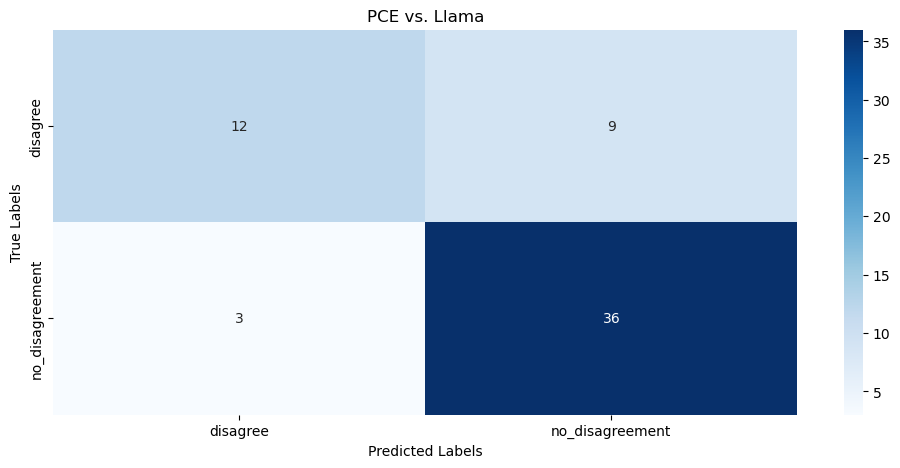

In [59]:

fig, axes = plt.subplots(1, 1, figsize=(12, 5))  

print_cm(
    axis=axes,
    df = result_thresholds,
     true_col = "majority_label",
    pred_col = "predictions_ft_0.65",
    title='PCE vs. Llama'
)

majority_label
no_disagreement    39
disagree           21
Name: count, dtype: int64
majority_label
no_disagreement    39
disagree           21
Name: count, dtype: int64


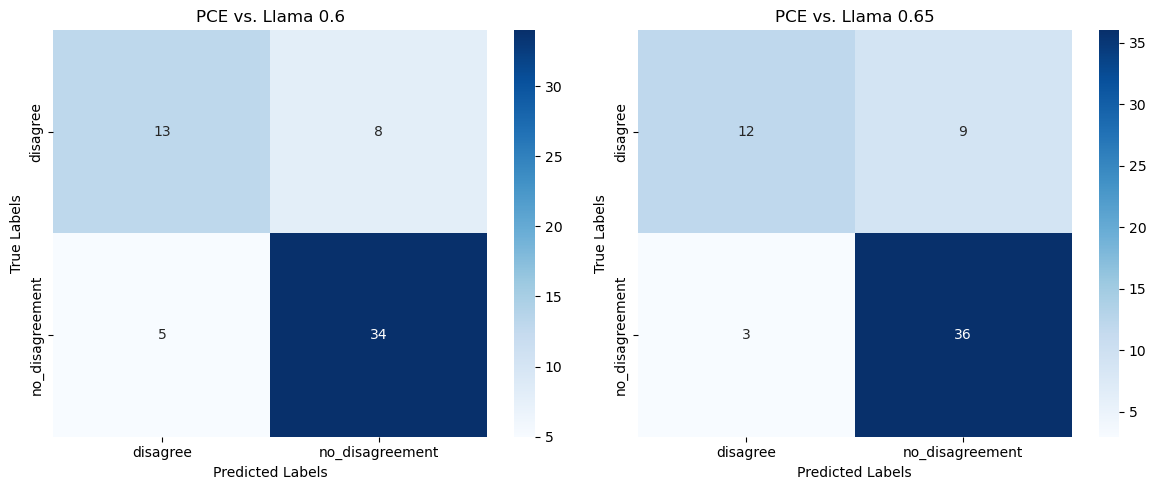

In [60]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
print_cm(
    axis=axes[0],
    df = result_thresholds,
    true_col = "majority_label",
    pred_col = "predictions_ft_0.6",
    title='PCE vs. Llama 0.6'
)

# Second matrix
print_cm(
    axis=axes[1],
    df = result_thresholds,
    true_col = "majority_label",
    pred_col = "predictions_ft_0.65",
    title='PCE vs. Llama 0.65'
)

plt.tight_layout()
plt.show()

# **ROC Precision-Recall**

In [73]:
result_thresholds

,submission_id,msg_id_parent,msg_id_child,prob_disagree,predictions_score_ft_0.5,predictions_ft_0.5,predictions_ft_0.55,predictions_ft_0.6,predictions_ft_0.65,predictions_ft_0.7,predictions_ft_0.75,predictions_ft_0.8,majority_label
0,d02aba,ez5hk92,ez5yhvc,0.037660,0.9624,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
1,4gqdyw,d2jsh7b,d2k49x6,0.149300,0.8506,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
2,9kru18,e719ohl,e719y1u,0.485000,0.5146,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,disagree
3,5oui9g,dcm9yt7,dcnqde5,0.004330,0.9956,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
4,4eakff,d1yfonw,d1ygjpd,0.272500,0.7275,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
5,pxu6lc,hermw07,hetwgsp,0.066600,0.9336,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement
6,27j18j,ci1ityc,ci1n1c7,0.885300,0.8853,disagree,disagree,disagree,disagree,disagree,disagree,disagree,disagree
7,jn2bon,gb05qjo,gb05rnn,0.849000,0.8490,disagree,disagree,disagree,disagree,disagree,disagree,disagree,no_disagreement
8,8we2i8,e2gbshk,e2go5cs,0.705600,0.7056,disagree,disagree,disagree,disagree,disagree,no_disagreement,no_disagreement,disagree
9,kzc2cq,gjp0hl0,gjrl8gu,0.044860,0.9550,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,no_disagreement,disagree


In [15]:

def plot_roc_pr_curves(y_true, y_scores, annotator, threshold_points=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]):
    
    # ROC
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- ROC Curve ---
    ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray')
    
    # Annotate thresholds on ROC curve
    for thresh in threshold_points:
        idx = np.argmin(np.abs(roc_thresholds - thresh))
        ax1.plot(fpr[idx], tpr[idx], 'o', label=f'Threshold {roc_thresholds[idx]:.2f}')
        ax1.annotate(f"{roc_thresholds[idx]:.2f}", (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,3), ha='center', fontsize=9)
    
    ax1.set_title("ROC Curve", fontsize=14)
    ax1.set_xlabel("False Positive Rate", fontsize=12)
    ax1.set_ylabel("True Positive Rate (Recall)", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # --- PR Curve ---
    ax2.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='blue', lw=2)
    
    # Annotate thresholds on PR curve
    for thresh in threshold_points:
        idx = np.argmin(np.abs(pr_thresholds - thresh))
        ax2.plot(recall[idx], precision[idx], 'o', label=f'Threshold {pr_thresholds[idx]:.2f}')
        ax2.annotate(f"{pr_thresholds[idx]:.2f}", (recall[idx], precision[idx]), textcoords="offset points", xytext=(10,3), ha='center', fontsize=9)
    
    ax2.set_title("Precision-Recall Curve", fontsize=14)
    ax2.set_xlabel("Recall", fontsize=14)
    ax2.set_ylabel("Precision", fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.suptitle(f"Compare Llama vs. {annotator}", fontsize = 16)
    plt.tight_layout()
    plt.savefig(f"plots/Llama_3.1_AttLoRa_{annotator}_OODval.pdf")
    plt.show()

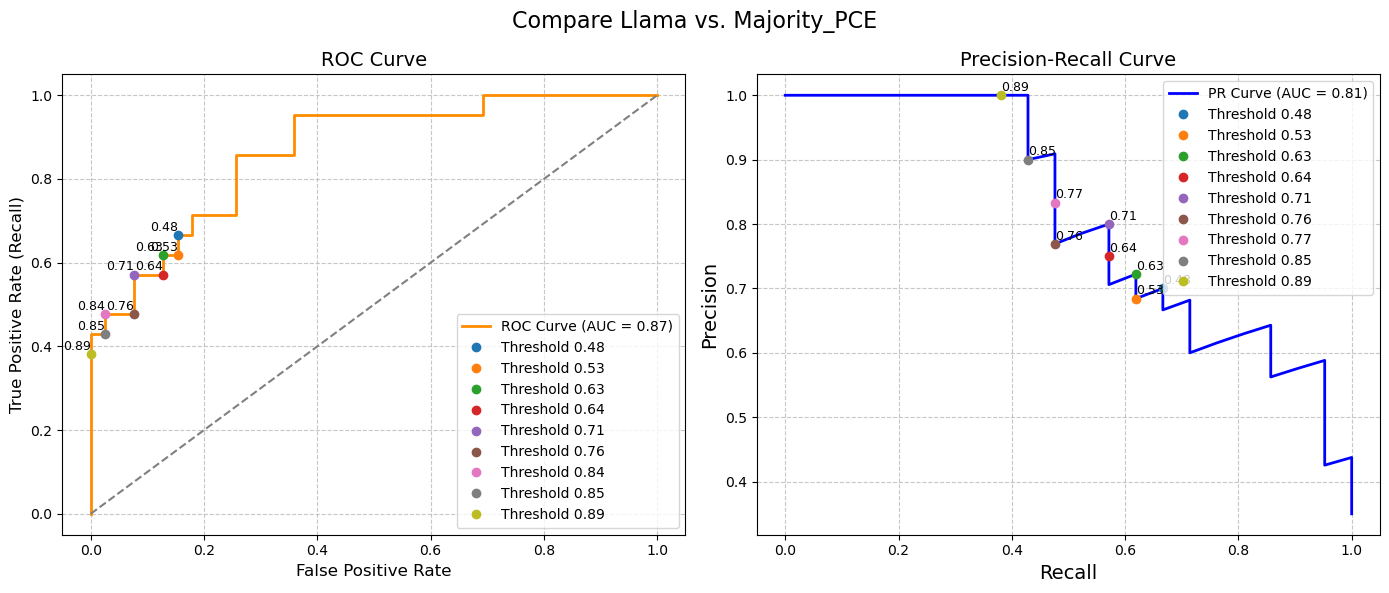

In [16]:
y_scores = result_thresholds['prob_disagree']
y_true = result_thresholds['majority_label'].apply(lambda x: 1 if x == 'disagree' else 0).values

plot_roc_pr_curves(y_true, y_scores, annotator = "Majority_PCE")
